In [ ]:
# default_exp bbox_canvas

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [ ]:
# hide
from nbdev import *

In [ ]:
# exporti
from math import log
from pathlib import Path
from copy import deepcopy
from enum import IntEnum
from typing import Dict, Optional, List

from ipyannotator.base import BaseState
from ipycanvas import MultiCanvas, hold_canvas
from ipywidgets import Image, Label, Layout, HBox, VBox, Output

# Draw Box in Canvas

In [ ]:
# hide

# Create a multi-layer canvas with 4 layers
multi_canvas = MultiCanvas(4, width=200, height=200)
multi_canvas[0] #  Access first layer (background)
multi_canvas[3] #  Access last layer
multi_canvas

In [ ]:
# hide
# dynamic update of canvas size
multi_canvas.width = 30
multi_canvas.height = 60

`ipyannotator` use `ipycanvas` to draw the Canvas. `ipycanvas` uses the following grid system:

![grid illustration](https://ipycanvas.readthedocs.io/en/latest/_images/grid.png)

In [ ]:
#exporti

def draw_bg(canvas, color='rgb(236,240,241)'):
    with hold_canvas(canvas):
        canvas.fill_style = color
        canvas.fill_rect(0, 0, canvas.size[0], canvas.size[1])

In [ ]:
# hide

from ipycanvas import Canvas
canvas = Canvas(width=300, height=20)
draw_bg(canvas)
canvas

In [ ]:
# hide
canvas = Canvas(width=200, height=200)
canvas.fill_rect(25, 25, 100, 100)
canvas.clear_rect(45, 45, 60, 60)
canvas.stroke_rect(50, 50, 50, 50)
canvas

In [ ]:
#exporti

def draw_bounding_box(canvas, coords: list, color='white', line_width=None,
                      border_ratio=2, clear=False, stroke_color='black'):
    with hold_canvas(canvas):
        if clear:
            canvas.clear()

        pos_x, pos_y, rect_x, rect_y = coords
        
        canvas.line_width = line_width or log(canvas.height) / 5
        gap = canvas.line_width * border_ratio
        
        canvas.stroke_color = stroke_color
        canvas.fill_style = color
        
        canvas.stroke_rect(pos_x, pos_y, rect_x, rect_y)
        canvas.fill_rect(pos_x, pos_y, rect_x, rect_y)
        canvas.stroke_rect(pos_x, pos_y, rect_x, rect_y)
        canvas.clear_rect(pos_x + gap, pos_y + gap, rect_x - 2 * gap,
                          rect_y - 2 * gap)
        canvas.stroke_rect(pos_x + gap, pos_y + gap, rect_x - 2 * gap,
                           rect_y - 2 * gap)

In [ ]:
# hide
import numpy as np

canvas = Canvas(width=100, height=100)
draw_bg(canvas)
draw_bounding_box(canvas, [0, 0, 80, 100])
draw_bounding_box(canvas, np.array([10, 40, 80, 100]) / 2, color='red', border_ratio=4, line_width=1.5)
canvas

In [ ]:
# hide
canvas = MultiCanvas(2, width=200, height=200)
draw_bg(canvas[0])
draw_bounding_box(canvas[1], [10, 40, 80, 100])
draw_bounding_box(canvas[1], np.array([10, 40, 80, 100]) / 2, color='red', border_ratio=4)
canvas

## Draw Image

`ipycanvas` can be used to draw images on the Canvas itself. This way, we can use `ipycanvas` with `ipywidgets` as the following to draw images.

In [ ]:

from ipywidgets import Image
from ipycanvas import Canvas

sprite1 = Image.from_file("../data/projects/bbox/pics/test200x200.png")
sprite2 = Image.from_file("../data/projects/bbox/pics/red400x640.png")

canvas = Canvas(width=300, height=300)

canvas.fill_style = '#a9cafc'
canvas.fill_rect(0, 0, 300, 300)

canvas.draw_image(sprite1, 50, 50)
canvas.draw_image(sprite2, 100, 100, width=40, height=40)

canvas

This code example will produce the following image:

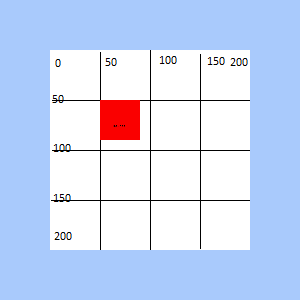

In [ ]:
# hide

# You can draw from another Canvas widget. This is the fastest way of drawing an image
# on the canvas.

canvas2 = Canvas(width=600, height=300)
# Here ``canvas`` is the canvas from the previous example
canvas2.draw_image(canvas, 0, 0)
canvas2.draw_image(canvas, 300, 0)
canvas2

In [ ]:
#exporti
from PIL import Image as pilImage

# can we do this without reading image?
def get_image_size(path):
    pil_im = pilImage.open(path)
    return pil_im.width, pil_im.height

In [ ]:
# hide
get_image_size("../data/projects/bbox/pics/red400x640.png")

### Draw resized Image

`ipyannotar` will rezise the image so it fits inside the Canvas. Over the process, the dimensions ratio will mantain constans.

In [ ]:
#export

def draw_img(canvas, file, clear=False, has_border=False):
    """
    draws resized image on canvas and returns scale used
    """
    with hold_canvas(canvas):
        if clear:
            canvas.clear()

        sprite1 = Image.from_file(file)

        width_canvas, height_canvas = canvas.width, canvas.height
        width_img, height_img = get_image_size(file)

        ratio_canvas = float(width_canvas) / height_canvas
        ratio_img = float(width_img) / height_img

        if ratio_img > ratio_canvas:
            # wider then canvas, scale to canvas width
            scale = width_canvas / width_img
        else:
            # taller then canvas, scale to canvas hight
            scale = height_canvas / height_img

        image_width = width_img * min(1, scale)
        image_height = height_img * min(1, scale)
        image_x = 0
        image_y = 0
        
        if has_border:
            canvas.stroke_rect(x=0, y=0, width=image_width, height=image_height)
            image_width -= 2
            image_height -= 2
            image_x, image_y = 1, 1
        
        canvas.draw_image(sprite1, 
                          image_x, 
                          image_y, 
                          width=image_width,
                          height=image_height)
        return scale

In [ ]:
# hide
file = "../data/projects/bbox/pics/red400x640.png"
canvas = Canvas(width=300, height=300)
draw_bg(canvas)
scale = draw_img(canvas, file)

canvas

In [ ]:
# hide
file = "../data/projects/bbox/pics/green640x400.png"
canvas = Canvas(width=300, height=300)
draw_bg(canvas)
scale = draw_img(canvas, file)
print(scale)
canvas

## Catch Drawing Events

drawing sequence:

- mouse press
- mouse move
- mouse release

The event only happens inside the area covered by the image

In [ ]:
# hide
file = "../data/projects/bbox/pics/green640x400.png"
canvas = Canvas(width=300, height=300)
draw_bg(canvas)
scale = draw_img(canvas, file)
print(scale)

In [ ]:
# hide
debug_view = Output(layout={'border': '1px solid black'})

state = {'active': False}

@debug_view.capture(clear_output=True)
def show_state():
    print(state)

@debug_view.capture(clear_output=True)
def update_start(x, y):
    print('start')
    state['active'] = True
    state['start'] = (x, y)
    # reset end
    state['end'] = state['start']
    show_state()

@debug_view.capture(clear_output=True)
def update_state(x, y):
    if state['active']:
        state['end'] = (x, y)
        show_state()
        
@debug_view.capture(clear_output=True)
def update_end(x, y):
    state['active'] = False
    state['end'] = (x, y)
    show_state()
        
canvas.on_mouse_down(update_start)
canvas.on_mouse_move(update_state)
canvas.on_mouse_up(update_end)

In [ ]:
# hide
canvas

In [ ]:
# hide
debug_view

In [ ]:
# hide
a = Image.from_file("../data/projects/bbox/pics/test200x200.png")

In [ ]:
#export

def points2bbox_coords(start_x, start_y, end_x, end_y) -> Dict[str, float]:
    min_x, max_x = sorted((start_x, end_x)) 
    min_y, max_y = sorted((start_y, end_y))
    return {'x': min_x, 'y': min_y, 'width': max_x - min_x, 'height': max_y - min_y}

In [ ]:
#export

def coords_point2bbox(bbox_coords: Dict[str, float]) -> List[float]:
    return [bbox_coords['x'],
            bbox_coords['y'],
            bbox_coords['width'],
            bbox_coords['height']]

In [ ]:
#export

def coords_scaled(bbox_coords: List[float], image_scale: float):
    return [value * image_scale for value in bbox_coords]

In [ ]:
#exporti

class BBoxLayer(IntEnum):
    bg = 0
    image = 1
    box = 2
    highlight = 3
    drawing = 4

In [ ]:
#exporti

class BBoxCanvasState(BaseState):
    image_path: Optional[str]
    bbox_coords: list = []
    image_scale: float = 1
    bbox_selected: Optional[int]
    height: Optional[float]
    width: Optional[float]

In [ ]:
#exporti

class BBoxCanvasGUI(HBox):
    debug_output = Output(layout={'border': '1px solid black'})
    
    def __init__(self, state: BBoxCanvasState, has_border: bool = False):
        super().__init__()

        self._state = state
        self._start_point = ()
        self.is_drawing = False
        self.has_border = has_border
        self.canvas_bbox_coords = {}
        
        # do not stick bbox to borders
        self.padding = 2
        
        # Define each of the children...
        self._image = Image(layout=Layout(display='flex',
                                          justify_content='center',
                                          align_items='center',
                                          align_content='center'))
        self.multi_canvas = MultiCanvas(
            len(BBoxLayer), 
            width=self._state.width,
            height=self._state.height
        )
        
        self.im_name_box = Label()
            
        children = [VBox([self.multi_canvas, self.im_name_box])]
        self.children = children
        draw_bg(self.multi_canvas[BBoxLayer.bg])
        
        # link drawing events        
        self.multi_canvas[BBoxLayer.drawing].on_mouse_move(self._update_pos)
        self.multi_canvas[BBoxLayer.drawing].on_mouse_down(self._start_drawing)
        self.multi_canvas[BBoxLayer.drawing].on_mouse_up(self._stop_drawing)    
    
    @property
    def highlight(self) -> Optional[dict]:
        return self._state.bbox_coords[self.bbox_selected]
    
    @highlight.setter
    def highlight(self, index: int):
        self.clear_layer(BBoxLayer.highlight)
        
        # unhighlight when double click
        if self._state.bbox_selected == index:
            self._state.set_quietly('bbox_selected', None)
            return
        
        bbox_coords = coords_point2bbox(self._state.bbox_coords[index])
        
        draw_bounding_box(
            self.multi_canvas[BBoxLayer.highlight],
            coords_scaled(bbox_coords, self._state.image_scale),
            stroke_color='yellow',
            border_ratio=3,
            color='yellow'
        )

        self._state.set_quietly('bbox_selected', index)
    
    @debug_output.capture(clear_output=False)
    def _update_pos(self, x, y):
        # print(f"-> BBoxCanvasGUI::_update_post({x}, {y})")
        if self.is_drawing:
            self.canvas_bbox_coords = points2bbox_coords(*self._start_point, x, y)
            self.draw_bbox(self.canvas_bbox_coords)
            # bbox should not cross the canvas border:
            if self._invalid_coords(x, y):
                print(' !! Out of canvas border !!')
                self._stop_drawing(x, y)
        # print(f"<- BBoxCanvasGUI::_update_post({x}, {y})")
                    
    def _invalid_coords(self, x, y) -> bool:
        return (self.canvas_bbox_coords["x"] + self.canvas_bbox_coords["width"] > self.multi_canvas.width - self.padding or
                self.canvas_bbox_coords["y"] + self.canvas_bbox_coords["height"] > self.multi_canvas.height - self.padding or
                self.canvas_bbox_coords["x"] < self.padding or
                self.canvas_bbox_coords["y"] < self.padding)
    
    @debug_output.capture(clear_output=False)
    def _stop_drawing(self, x, y):
        print(f"-> BBoxCanvasGUI::_stop_drawing({x}, {y})")
        self.is_drawing = False
        
        # if something is drawn
        if self.canvas_bbox_coords:
            # if bbox is not human visible, clean:
            if (self.canvas_bbox_coords['width'] < 10 or 
                self.canvas_bbox_coords['height'] < 10):
                self.clear_layer(BBoxLayer.drawing)
                print(" !! too small bbox drawn !!")
            else: # otherwise, save bbox values to backend
                tmp_bbox_coords = deepcopy(self._state.bbox_coords)
                tmp_bbox_coords.append(
                    dict(
                        { k: v / self._state.image_scale for k, v in self.canvas_bbox_coords.items() }
                    )
                )
                self._state.bbox_coords = tmp_bbox_coords
            self.canvas_bbox_coords = {}
        # print(f"<- BBoxCanvasGUI::_stop_drawing({x}, {y})")        
    
    def draw_bbox(self, canvas_bbox_coords: dict, color='white'):
        # print('-> Observe canvas_coords: ', canvas_bbox_coords)
        if not canvas_bbox_coords:
            self.clear_layer(BBoxLayer.box)
            self._state.bbox_coords = []
            return
        
        coords = coords_point2bbox(canvas_bbox_coords)
        
        draw_bounding_box(
            self.multi_canvas[BBoxLayer.drawing], 
            coords,
            color='white', 
            border_ratio=2, 
            clear=True
        )
        # print('<- Observe canvas_coords')
    
    def clear_layer(self, layer: int):
        self.multi_canvas[layer].clear()
    
    @debug_output.capture(clear_output=True)            
    def _start_drawing(self, x, y):
        # print(f"-> BBoxCanvasGUI::_start_drawing({x}, {y})")
        self._start_point = (x, y)
        self.is_drawing = True
        # print(f"<- BBoxCanvasGUI::_start_drawing({x}, {y})")

In [ ]:
# it can highlight

bbox_canvas_state = BBoxCanvasState(
    **{
        'width':100, 
        'height':100,
        'bbox_coords': [{'x': 10, 'y': 20, 'width': 50, 'height': 50}]
    }
)

gui = BBoxCanvasGUI(bbox_canvas_state)
gui.highlight = 0
gui

In [ ]:
#exporti

class BBoxCanvasController:
    """
    Handle the GUI and state communication
    """
    debug_output = Output(layout={'border': '1px solid black'})
    
    def __init__(self, gui: BBoxCanvasGUI, state: BBoxCanvasState):
        self._state = state
        self._gui = gui
        
        state.subscribe(self._update_canvas_bbox_coords, 'bbox_coords')
        state.subscribe(self._draw_image, 'image_path')

    @debug_output.capture(clear_output=True)
    def _update_canvas_bbox_coords(self, bbox_coords: dict):
        # print('-> Observe bbox_coords: ', bbox_coords)
        self._draw_all_bbox()

    @debug_output.capture(clear_output=True)
    def _draw_all_bbox(self):
        # print(f"-> BBoxCanvasController::_draw_all_bbox")
        
        self._gui.clear_layer(BBoxLayer.box)
        self._gui.clear_layer(BBoxLayer.highlight)
        self._gui.clear_layer(BBoxLayer.drawing)
        
        for data in self._state.bbox_coords:
            coords = coords_point2bbox(data)
            
            draw_bounding_box(
                self._gui.multi_canvas[BBoxLayer.box], 
                coords_scaled(coords, self._state.image_scale),
                color='white',
                border_ratio=2,
                clear=False
            )
        # print(f"<- BBoxCanvasController::_draw_all_bbox")
        
    def clear_all_bbox(self):
        self._gui.clear_layer(BBoxLayer.box)
        self._gui.clear_layer(BBoxLayer.highlight)
        self._gui.clear_layer(BBoxLayer.drawing)
        self._state.bbox_coords = []
    
    @debug_output.capture(clear_output=True)
    def _draw_image(self, image_path: str):
        # print(f"-> _draw_image {image_path}")
        self.clear_all_bbox()
        self._state.image_scale = draw_img(
            self._gui.multi_canvas[BBoxLayer.image], 
            image_path, 
            clear=True,
            has_border=self._gui.has_border
        )
        self._gui.im_name_box.value = Path(image_path).name
        # print(f"<- _draw_image {image_path}")

In [ ]:
#export

class BBoxCanvas(BBoxCanvasGUI):
    """
    Represents canvas holding image and bbox ontop. 
    Gives user an ability to draw a bbox with mouse.
    """

    def __init__(self, width, height, has_border: bool = False):
        self.state = BBoxCanvasState(
            uuid=id(self),
            **{'width': width, 'height': height}
        )
        super().__init__(state=self.state, has_border=has_border)
        self._controller = BBoxCanvasController(gui=self, state=self.state)
        self._bbox_history = []
    
    def undo_bbox(self):
        if self.state.bbox_coords:
            tmp_bbox_coords = deepcopy(self.state.bbox_coords)
            removed_bbox = tmp_bbox_coords.pop()
            self._bbox_history = [removed_bbox]
            self.state.bbox_coords = tmp_bbox_coords
    
    def redo_bbox(self):
        if self._bbox_history:
            tmp_bbox_coords = deepcopy(self.state.bbox_coords)
            tmp_bbox_coords.append(self._bbox_history.pop())
            self.state.bbox_coords = tmp_bbox_coords
            
    def clear_all_bbox(self):
        self._controller.clear_all_bbox()

    def observe_client_ready(self, cb=None):
        self.multi_canvas.on_client_ready(cb)

![](http://www.plantuml.com/plantuml/png/bP5DQiCm48NtEiL0DmdK5yWY1DehT2t6qZWnbJL6FtPo-rfIxQIj25JWXVK-FTwyEVc0BiJ125I17NnuSl0oN_f0Gh4DZWsyePtG2o6Is1pBxm46Zfv0ysp5sN4SuTtXtDkpA41pxDnYG5OVWAtCjCpqUlz8o9n3wcyBmpn2nmu8rGL6xXVCmS0J2LXEBSWcbcjeZd2ttrrVuRRFCfe0FYf5tdVHW4AVdfLJInP73MtBLwcOdVOLTisHmcSqCsGy0SS0t85AnD-dMyQr0Xwt1ZQBc3QIfErvRVfubv_KNwZ_PR1QfAzMpOIcrnW8P1bGFlPKx_bvRtdWYTmD_836mCwoRQRUzwsXVK7g5ieGMlWLj4NrkQuG0_tOucaHuc2-0000)

In [ ]:
# hide
gui = BBoxCanvas(width=100, height=100, has_border=True)
gui

In [ ]:
# hide
gui.debug_output

In [ ]:
gui._controller.debug_output

In [ ]:
gui._state.bbox_coords

In [ ]:
# hide
# gui._state.image_path = "../data/projects/bbox/pics/red400x640.png"
gui._state.image_path = '../data/projects/im2im1/class_images/blocks_1.png'

In [ ]:
# hide

tpm_bbox_coords = gui._state.bbox_coords
# tpm_bbox_coords[0] = {'x':5, 'y': 10, 'width': 5, 'height': 5}
tpm_bbox_coords.append({'x': 5, 'y': 10, 'width': 20, 'height': 30})
gui._state.bbox_coords = tpm_bbox_coords

In [ ]:
gui._state.image_scale

In [ ]:
# hide

tpm_bbox_coords = gui._state.bbox_coords
tpm_bbox_coords.append({'x': 10, 'y': 10, 'width': 20, 'height': 30})
gui._state.bbox_coords = tpm_bbox_coords

In [ ]:
gui._state.bbox_coords

In [ ]:
# it can undo bbox_coords

assert len(gui._state.bbox_coords) == 2
gui.undo_bbox()
assert len(gui._state.bbox_coords) == 1
gui.undo_bbox()

In [ ]:
# it can redo the last undo

assert len(gui._state.bbox_coords) == 0
gui.redo_bbox()
assert len(gui._state.bbox_coords) == 1
gui.redo_bbox()
assert len(gui._state.bbox_coords) == 1

In [ ]:
scaled = lambda coords: {k:(v/gui._state.image_scale) for k, v in coords.items()}

# it cant draw small bbox
small_coords = {'height': 5, 'width': 5, 'x': 5, 'y': 5}
gui.canvas_bbox_coords = small_coords

gui._stop_drawing(small_coords['x'], small_coords['y']) # mouse up

assert scaled(small_coords) not in gui._state.bbox_coords

# it can draw bbox
bigger_coords = {'height': 11, 'width': 11, 'x': 11, 'y': 11}
gui.canvas_bbox_coords = bigger_coords

gui._stop_drawing(bigger_coords['x'], bigger_coords['y']) # mouse up

assert scaled(bigger_coords) in gui._state.bbox_coords

In [ ]:
gui.clear_all_bbox()

In [ ]:
#hide
from nbdev.export import *
notebook2script()